# =====================================================
# 0. Imports, project root, config
# =====================================================

In [170]:
from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot

plt.style.use("default")  # or your preferred style

def get_project_root(marker: str = "woodgreen-data") -> Path:
    """Return the project root (directory that contains `marker`)."""
    env = os.getenv("CONCORDIA_PROJECT_ROOT")
    if env:
        root = Path(env).resolve()
        if (root / marker).is_dir():
            return root
        raise RuntimeError(f"CONCORDIA_PROJECT_ROOT={root!r} has no '{marker}' dir")

    start = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()
    for p in (start, *start.parents):
        if (p / marker).is_dir():
            return p

    raise RuntimeError(f"Could not find '{marker}' starting from {start}")

# Date columns we search for the first contact date
DATE_COLS = [
    "Creation Date",
    "Last Modified",
    "program_startdate_DC",
    "program_enddate_DC",
    "Start Date_AC",
    "Discharge Date_AC",
    "Client Date Enrolled_AC",
    "Client Intake Date_AC",
    "RG_date_HB",
    "Service Start Date_CC",
    "Modified On_CC",
    "MODIFIEDON_TR",
    "DischargeDateY-M-D_TR",
]

# Column groups for demographic subtables
GROUPS = {
    "demographics_sex_age.csv": [
        "Unique Record ID",
        "Sex",
        "Marital Status",
        "Year of Birth",
        "Age_AC",
    ],
    "demographics_geography.csv": [
        "Unique Record ID",
        "Birth Province / Country Code",
        "Home Province Code",
        "Client City_AC",
        "City_CC",
        "City_CU",
        "ClientAddressCity_TR",
    ],
    "demographics_race_ethnicity_religion.csv": [
        "Unique Record ID",
        "Client Race/Background (Identity) 1_AC",
        "Race_CU",
        "Culture_CU",
        "Religion_CU",
    ],
    "demographics_language.csv": [
        "Unique Record ID",
        "cims client preferred language_AC",
        "Client Preferred Language_AC",
        "PreferredLanguage_CU",
    ],
    "demographics_immigration_status.csv": [
        "Unique Record ID",
        "Citizenship_CU",
        "Citizenship_TR",
        "Status in Canada_YD",
        "Newcommer_YD",
    ],
}

# =====================================================
# 1. Build demographic tables
# =====================================================

In [171]:
def build_demographic_tables() -> None:
    root = get_project_root()
    data_dir = root / "woodgreen-data"
    out_dir = root / "ethnicity_forecasting"
    input_file = data_dir / "WoodGreen_All_Systems.csv"

    print("Project root:", root)
    print("Input file:  ", input_file)
    print("Output dir:  ", out_dir)

    if not input_file.exists():
        raise FileNotFoundError(f"Input CSV not found at: {input_file}")

    out_dir.mkdir(exist_ok=True)

    df = pd.read_csv(input_file, low_memory=False)

    # --- build EarliestDate + source ---
    existing_date_cols = [c for c in DATE_COLS if c in df.columns]
    if not existing_date_cols:
        raise ValueError("None of the expected date columns were found in the data.")

    df[existing_date_cols] = df[existing_date_cols].apply(
        pd.to_datetime, errors="coerce"
    )

    df["EarliestDate"] = df[existing_date_cols].min(axis=1)
    df = df[df["EarliestDate"].notna()].copy()
    df["EarliestDateSource"] = df[existing_date_cols].idxmin(axis=1)

    # --- one CSV per demographic group ---
    for filename, cols in GROUPS.items():
        cols = [c for c in cols if c in df.columns]
        if not cols:
            print(f"Skipping {filename}: no matching columns.")
            continue

        mask = df[cols].notna().any(axis=1)
        table = df.loc[mask, cols + ["EarliestDate", "EarliestDateSource"]].copy()

        # drop empty columns
        empty_cols = [c for c in table.columns if table[c].isna().all()]
        if empty_cols:
            table = table.drop(columns=empty_cols)

        # fill NA in string columns with "Unknown"
        meta_cols = ["Unique Record ID", "EarliestDate", "EarliestDateSource"]
        cat_cols = [
            c for c in table.columns
            if c not in meta_cols and table[c].dtype == "object"
        ]
        if cat_cols:
            table[cat_cols] = table[cat_cols].fillna("Unknown")

        out_path = out_dir / filename
        table.to_csv(out_path, index=False)
        print(f"Saved {filename} with {len(table)} rows, {len(table.columns)} cols.")

build_demographic_tables()

Project root: C:\Users\emili\IdeaProjects\PythonProject\ConcordIA
Input file:   C:\Users\emili\IdeaProjects\PythonProject\ConcordIA\woodgreen-data\WoodGreen_All_Systems.csv
Output dir:   C:\Users\emili\IdeaProjects\PythonProject\ConcordIA\ethnicity_forecasting
Saved demographics_sex_age.csv with 103427 rows, 7 cols.
Saved demographics_geography.csv with 103427 rows, 8 cols.
Saved demographics_race_ethnicity_religion.csv with 103427 rows, 4 cols.
Saved demographics_language.csv with 103427 rows, 5 cols.
Saved demographics_immigration_status.csv with 103427 rows, 4 cols.


# =====================================================
# 2. Build unified demographics + base targets
# =====================================================

In [172]:
def build_targets() -> None:
    root = get_project_root()
    dem_dir = root / "ethnicity_forecasting"
    out_dir = dem_dir

    files = [
        dem_dir / "demographics_sex_age.csv",
        dem_dir / "demographics_geography.csv",
        dem_dir / "demographics_race_ethnicity_religion.csv",
        dem_dir / "demographics_language.csv",
        dem_dir / "demographics_immigration_status.csv",
    ]

    dfs = []
    for path in files:
        if not path.exists():
            print(f"WARNING: {path.name} not found, skipping")
            continue

        df = pd.read_csv(path)
        df["EarliestDate"] = pd.to_datetime(df["EarliestDate"], errors="coerce")
        df = df[df["EarliestDate"].notna()].copy()

        df = df.sort_values(["Unique Record ID", "EarliestDate"])
        df = df.drop_duplicates(
            subset=["Unique Record ID", "EarliestDate"],
            keep="first",
        )

        dfs.append(df)
        print(f"Loaded {path.name} with shape {df.shape}")

    if not dfs:
        raise RuntimeError("No demographics tables loaded.")

    unified = reduce(
        lambda left, right: pd.merge(
            left,
            right,
            on=["Unique Record ID", "EarliestDate", "EarliestDateSource"],
            how="outer",
        ),
        dfs,
    )

    unified = unified.sort_values(["Unique Record ID", "EarliestDate"])
    unified = unified.drop_duplicates(subset=["Unique Record ID"], keep="first")

    root = get_project_root()
    out_dir = root / "ethnicity_forecasting"
    unified_out = out_dir / "unified_demographics.csv"
    unified.to_csv(unified_out, index=False)
    print("Saved unified demographics:", unified_out)
    print("Unified shape:", unified.shape)

    # ---- daily + weekly total new clients (all time) ----
    unified["EarliestDate"] = pd.to_datetime(unified["EarliestDate"], errors="coerce")
    unified = unified[unified["EarliestDate"].notna()].copy()

    daily_counts = (
        unified.groupby("EarliestDate")["Unique Record ID"]
        .nunique()
        .sort_index()
    )
    daily_counts_full = daily_counts.asfreq("D", fill_value=0)
    daily_out = out_dir / "target_daily_new_clients.csv"
    daily_counts_full.to_csv(daily_out)
    print("Saved:", daily_out)

    weekly_counts = daily_counts_full.resample("W-SUN").sum()
    weekly_counts.name = "weekly_new_clients"
    weekly_out = out_dir / "target_weekly_new_clients.csv"
    weekly_counts.to_csv(weekly_out)
    print("Saved:", weekly_out)

build_targets()

Loaded demographics_sex_age.csv with shape (80951, 7)
Loaded demographics_geography.csv with shape (89556, 8)
Loaded demographics_race_ethnicity_religion.csv with shape (89556, 4)
Loaded demographics_language.csv with shape (89556, 5)
Loaded demographics_immigration_status.csv with shape (89556, 4)
Saved unified demographics: C:\Users\emili\IdeaProjects\PythonProject\ConcordIA\ethnicity_forecasting\unified_demographics.csv
Unified shape: (80546, 16)
Saved: C:\Users\emili\IdeaProjects\PythonProject\ConcordIA\ethnicity_forecasting\target_daily_new_clients.csv
Saved: C:\Users\emili\IdeaProjects\PythonProject\ConcordIA\ethnicity_forecasting\target_weekly_new_clients.csv


# =====================================================
# 3. Filter to 2021+ and re-make targets (cleaned)
# =====================================================

In [173]:
root = get_project_root()
out_dir = root / "ethnicity_forecasting"

unified = pd.read_csv(out_dir / "unified_demographics.csv",
                      parse_dates=["EarliestDate"])

clean_unified = unified[unified["EarliestDate"] >= "2021-01-01"].copy()
print("Original rows:", len(unified))
print("Filtered rows (2021+):", len(clean_unified))

clean_unified_out = out_dir / "unified_demographics_cleaned.csv"
clean_unified.to_csv(clean_unified_out, index=False)
print("Saved:", clean_unified_out)

# ---- daily + weekly targets for 2021+ ----
daily_counts = (
    clean_unified
    .groupby("EarliestDate")["Unique Record ID"]
    .nunique()
    .sort_index()
)
daily_counts = daily_counts.asfreq("D", fill_value=0)
daily_out = out_dir / "target_daily_new_clients_cleaned.csv"
daily_counts.to_csv(daily_out)
print("Saved:", daily_out)

weekly_counts = daily_counts.resample("W-SUN").sum()
weekly_counts.name = "weekly_new_clients"
weekly_out = out_dir / "target_weekly_new_clients_cleaned.csv"
weekly_counts.to_csv(weekly_out)
print("Saved:", weekly_out)

weekly_counts.head()

Original rows: 80546
Filtered rows (2021+): 71486
Saved: C:\Users\emili\IdeaProjects\PythonProject\ConcordIA\ethnicity_forecasting\unified_demographics_cleaned.csv
Saved: C:\Users\emili\IdeaProjects\PythonProject\ConcordIA\ethnicity_forecasting\target_daily_new_clients_cleaned.csv
Saved: C:\Users\emili\IdeaProjects\PythonProject\ConcordIA\ethnicity_forecasting\target_weekly_new_clients_cleaned.csv


EarliestDate
2021-01-03    38
2021-01-10    61
2021-01-17    12
2021-01-24    11
2021-01-31    10
Freq: W-SUN, Name: weekly_new_clients, dtype: int64

# =====================================================
# 4. EDA: weekly totals
# =====================================================

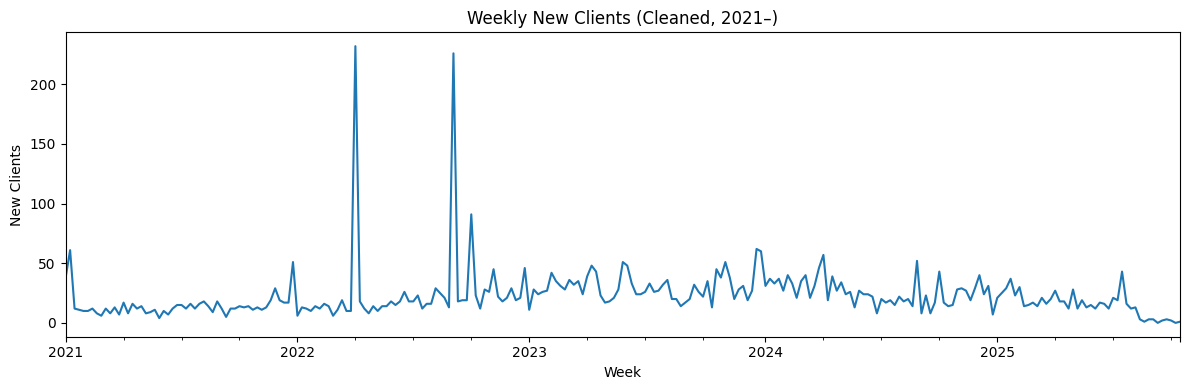

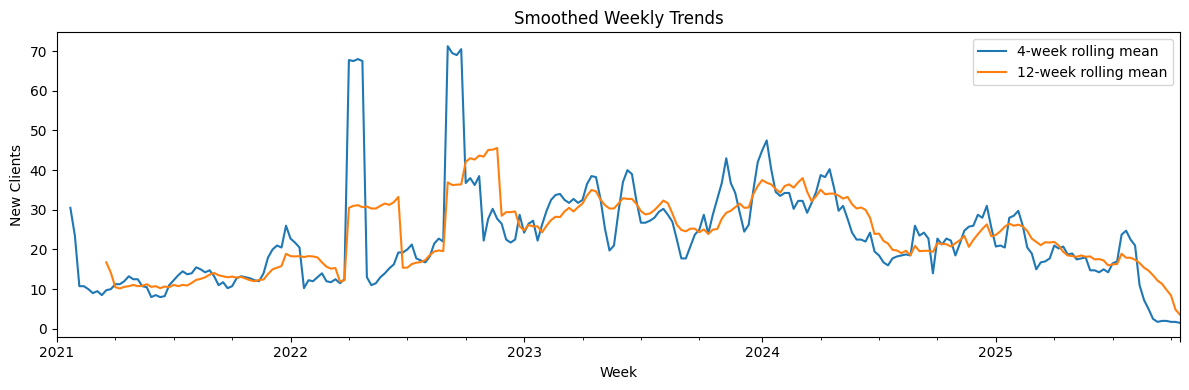

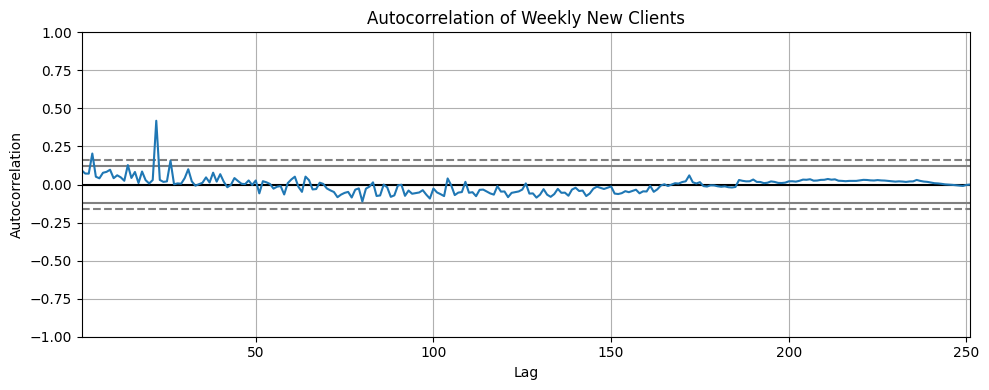

In [174]:
plt.figure(figsize=(12, 4))
weekly_counts.plot()
plt.title("Weekly New Clients (Cleaned, 2021–)")
plt.xlabel("Week")
plt.ylabel("New Clients")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
weekly_counts.rolling(4).mean().plot(label="4-week rolling mean")
weekly_counts.rolling(12).mean().plot(label="12-week rolling mean")
plt.title("Smoothed Weekly Trends")
plt.xlabel("Week")
plt.ylabel("New Clients")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
autocorrelation_plot(weekly_counts)
plt.title("Autocorrelation of Weekly New Clients")
plt.tight_layout()
plt.show()

# =====================================================
# 5. Load cleaned unified + weekly targets for modeling
# =====================================================

In [175]:
root = get_project_root()
out_dir = root / "ethnicity_forecasting"

weekly = pd.read_csv(
    out_dir / "target_weekly_new_clients_cleaned.csv",
    parse_dates=["EarliestDate"],
    index_col="EarliestDate",
).asfreq("W-SUN")

unified = pd.read_csv(
    out_dir / "unified_demographics_cleaned.csv",
    parse_dates=["EarliestDate"],
)

weekly.head(), unified.head()

(              weekly_new_clients
 EarliestDate                    
 2021-01-03                    38
 2021-01-10                    61
 2021-01-17                    12
 2021-01-24                    11
 2021-01-31                    10,
                        Unique Record ID      Sex Marital Status  \
 0  0001a429-2779-eb11-b1ab-000d3a0c0477      Man         Single   
 1  0002a429-2779-eb11-b1ab-000d3a0c0477      Man        Unknown   
 2  0009e160-475b-f011-877b-0022483c7cc7  Unknown        Unknown   
 3  000adf91-5683-471b-98b8-cc1caecec514    Woman        Married   
 4  000d12e4-d497-4ac1-9266-5d97e85691e8    Woman        Unknown   
 
    Year of Birth  Age_AC        EarliestDate EarliestDateSource  \
 0         1966.0     NaN 2021-02-27 18:48:30      Creation Date   
 1         1978.0     NaN 2021-02-27 18:48:56      Creation Date   
 2         1988.0     NaN 2025-07-07 15:31:07      Creation Date   
 3         1993.0     NaN 2022-09-26 15:25:58      Creation Date   
 4         

# =====================================================
# 6. Identity cleaning + broad mapping
# =====================================================

In [176]:
identity_col = "Client Race/Background (Identity) 1_AC"

# Normalize identity text
unified[identity_col] = (
    unified[identity_col]
    .fillna("Unknown")
    .astype(str)
    .str.strip()
    .str.title()
    .replace(["", "Nan", "Na"], "Unknown")
)

# Map detailed categories to broad groups
identity_map = {
    "Black (African)": "Black",
    "Black (North/South American. Caribbean. European)": "Black",
    "Caucasian/White": "White",
    "European)": "White",
    "Chinese": "East Asian",
    "Japanese": "East Asian",
    "Filipino": "Southeast Asian",
    "Southeast Asian (E.G. Vietnamese": "Southeast Asian",
    "South Asian": "South Asian",
    "Middle Eastern": "Middle Eastern",
    "Hispanic": "Latin American",
    "First Nations/Metis/Indigenous": "Indigenous",
    "Multiple Ethnicities": "Multiple",
    "Other": "Other",
}

unified["IdentityBroad"] = (
    unified[identity_col]
    .replace(identity_map)
    .fillna("Unknown")
)

unified[[identity_col, "IdentityBroad"]].head()

,Client Race/Background (Identity) 1_AC,IdentityBroad
0,Unknown,Unknown
1,Unknown,Unknown
2,Unknown,Unknown
3,Unknown,Unknown
4,Unknown,Unknown


Autocorrelation (seasonality detection)

# =====================================================
# 7. Helper: weekly_by_category
# =====================================================

In [177]:
def weekly_by_category(df, category_col):
    """Return weekly counts (Sunday week) of new clients by category."""
    df = df.copy()
    df = df[df[category_col].notna()].copy()
    df["EarliestDate"] = pd.to_datetime(df["EarliestDate"], errors="coerce")
    df = df[df["EarliestDate"].notna()].copy()

    df["Week"] = df["EarliestDate"].dt.to_period("W-SUN").dt.start_time

    grouped = (
        df
        .groupby(["Week", category_col])["Unique Record ID"]
        .nunique()
        .unstack(fill_value=0)
        .sort_index()
    )
    return grouped

# =====================================================
# 8. Weekly new clients by identity (raw & broad)
# =====================================================

In [178]:
# Detailed identity
weekly_identity = weekly_by_category(unified, identity_col)
print("weekly_identity shape:", weekly_identity.shape)

# Broad identity
weekly_identity_broad = weekly_by_category(unified, "IdentityBroad")
print("weekly_identity_broad shape:", weekly_identity_broad.shape)

# Save broad version for other tools
weekly_identity_out = out_dir / "weekly_new_clients_by_identity_broad.csv"
weekly_identity_broad.to_csv(weekly_identity_out)
print("Saved:", weekly_identity_out)

weekly_identity shape: (251, 15)
weekly_identity_broad shape: (251, 11)
Saved: C:\Users\emili\IdeaProjects\PythonProject\ConcordIA\ethnicity_forecasting\weekly_new_clients_by_identity_broad.csv


# =====================================================
# 9. Plot: Weekly new clients by identity (Top 5, no Unknown)
# =====================================================

Top 5 identity groups (raw): ['Caucasian/White', 'South Asian', 'European)', 'Chinese', 'Southeast Asian (E.G. Vietnamese']


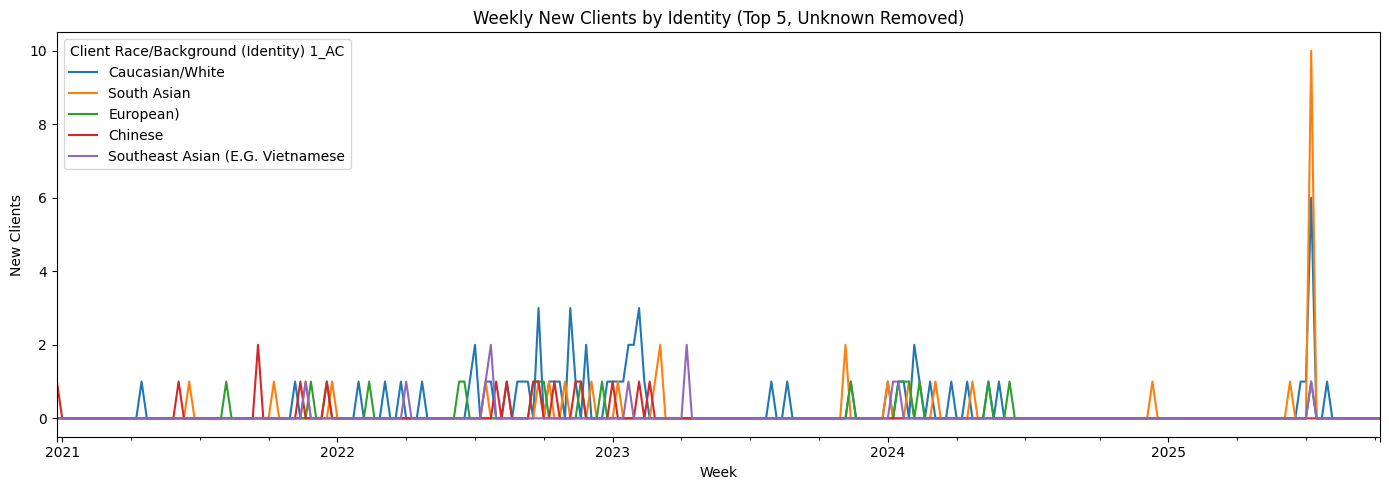

In [179]:
plot_df = weekly_identity.copy()

# Drop Unknown if present
if "Unknown" in plot_df.columns:
    plot_df = plot_df.drop(columns=["Unknown"])

# Keep only groups that ever occur
plot_df = plot_df.loc[:, (plot_df.sum() > 0)]

# Ensure numeric
plot_df = plot_df.apply(pd.to_numeric, errors="coerce")

# Top 5 identity groups by total volume
top5 = (
    plot_df
    .sum(axis=0)
    .sort_values(ascending=False)
    .head(5)
    .index
)
print("Top 5 identity groups (raw):", list(top5))

plt.figure(figsize=(14, 5))
plot_df[top5].plot(ax=plt.gca())
plt.title("Weekly New Clients by Identity (Top 5, Unknown Removed)")
plt.xlabel("Week")
plt.ylabel("New Clients")
plt.tight_layout()
plt.show()

# =====================================================
# 10. Plot: Weekly identity composition (% of total)
# =====================================================

<Figure size 1400x600 with 0 Axes>

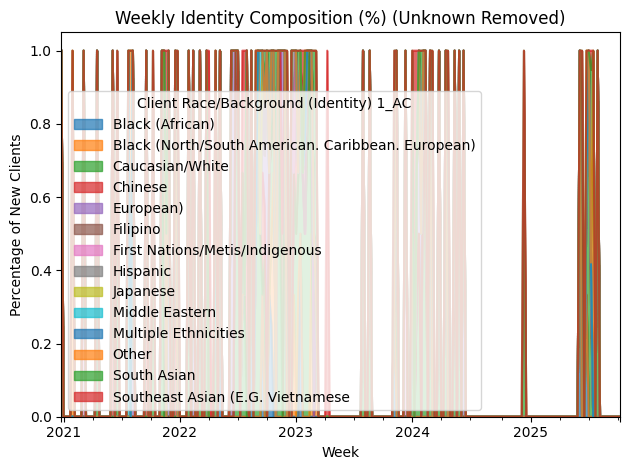

In [180]:
comp_df = weekly_identity.copy()

# Drop Unknown if you don't want it in the stack
if "Unknown" in comp_df.columns:
    comp_df = comp_df.drop(columns=["Unknown"])

comp_df = comp_df.loc[:, (comp_df.sum() > 0)]
comp_df = comp_df.apply(pd.to_numeric, errors="coerce")

weekly_identity_pct = comp_df.div(comp_df.sum(axis=1), axis=0)

plt.figure(figsize=(14, 6))
weekly_identity_pct.plot(kind="area", alpha=0.7)
plt.title("Weekly Identity Composition (%) (Unknown Removed)")
plt.xlabel("Week")
plt.ylabel("Percentage of New Clients")
plt.tight_layout()
plt.show()

# =====================================================
# 11. Prepare broad weekly identity table for forecasting
# =====================================================

In [181]:
weekly_identity_broad_clean = weekly_identity_broad.copy()

# Drop Unknown
if "Unknown" in weekly_identity_broad_clean.columns:
    weekly_identity_broad_clean = weekly_identity_broad_clean.drop(columns=["Unknown"])

# Drop columns that are always zero
weekly_identity_broad_clean = weekly_identity_broad_clean.loc[
    :, (weekly_identity_broad_clean.sum() > 0)
]

# Ensure numeric
weekly_identity_broad_clean = weekly_identity_broad_clean.astype(float)

print("Clean broad weekly shape:", weekly_identity_broad_clean.shape)
weekly_identity_broad_clean.head()

Clean broad weekly shape: (251, 10)


IdentityBroad,Black,East Asian,Indigenous,Latin American,Middle Eastern,Multiple,Other,South Asian,Southeast Asian,White
Week,,,,,,,,,,
2020-12-28,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# =====================================================
# 12. ARIMA forecasting by broad identity group
# =====================================================

In [182]:
root = get_project_root()
out_dir = root / "ethnicity_forecasting"
out_dir.mkdir(exist_ok=True, parents=True)

for col in weekly_identity_broad_clean.columns:
    print(f"\n=== Forecasting: {col} ===")

    y = weekly_identity_broad_clean[col].copy()
    y.index = pd.to_datetime(y.index)
    y = y.asfreq("W-SUN")
    y = y.replace([np.inf, -np.inf], np.nan).dropna()

    if len(y) < 30:
        print(f"Skipping {col}: series too short ({len(y)} points).")
        continue

    split_idx = int(len(y) * 0.8)
    y_train = y.iloc[:split_idx]
    y_test = y.iloc[split_idx:]  # not used yet but kept for future evaluation

    try:
        model = ARIMA(y_train, order=(2, 0, 1))
        model_fit = model.fit()
    except Exception as e:
        print(f"ARIMA failed for {col}: {e}")
        continue

    # Forecast 52 weeks ahead
    n_future = 52
    future_vals = model_fit.forecast(steps=n_future)
    future_index = pd.date_range(
        start=y.index[-1] + pd.Timedelta(weeks=1),
        periods=n_future,
        freq="W-SUN",
    )
    future_series = pd.Series(future_vals, index=future_index, name=f"{col}_forecast")

    # Save forecast
    out_path = out_dir / f"arima_broad_{col.replace(' ', '_')}.csv"
    future_series.to_csv(out_path, header=True)
    print("Saved forecast:", out_path)

    # Plot history + forecast
    plt.figure(figsize=(10, 4))
    plt.plot(y.index, y, label="History")
    plt.plot(future_series.index, future_series, label="Forecast")
    plt.title(f"ARIMA(2,0,1) – {col}")
    plt.xlabel("Week")
    plt.ylabel("New Clients")
    plt.legend()
    plt.tight_layout()
    plt.show()


=== Forecasting: Black ===
Skipping Black: series too short (0 points).

=== Forecasting: East Asian ===
Skipping East Asian: series too short (0 points).

=== Forecasting: Indigenous ===
Skipping Indigenous: series too short (0 points).

=== Forecasting: Latin American ===
Skipping Latin American: series too short (0 points).

=== Forecasting: Middle Eastern ===
Skipping Middle Eastern: series too short (0 points).

=== Forecasting: Multiple ===
Skipping Multiple: series too short (0 points).

=== Forecasting: Other ===
Skipping Other: series too short (0 points).

=== Forecasting: South Asian ===
Skipping South Asian: series too short (0 points).

=== Forecasting: Southeast Asian ===
Skipping Southeast Asian: series too short (0 points).

=== Forecasting: White ===
Skipping White: series too short (0 points).


# =====================================================
# 13. Still working on this...
# =====================================================

In [183]:
print("weekly_identity_broad shape:", weekly_identity_broad.shape)
print("\nSum of each column:\n", weekly_identity_broad.sum())
print("\nAny non-zero?\n", (weekly_identity_broad.sum() > 0))

weekly_identity_broad shape: (251, 11)

Sum of each column:
 IdentityBroad
Black                 17
East Asian            17
Indigenous             3
Latin American         1
Middle Eastern         2
Multiple               1
Other                  6
South Asian           31
Southeast Asian       13
Unknown            71314
White                 81
dtype: int64

Any non-zero?
 IdentityBroad
Black              True
East Asian         True
Indigenous         True
Latin American     True
Middle Eastern     True
Multiple           True
Other              True
South Asian        True
Southeast Asian    True
Unknown            True
White              True
dtype: bool


In [184]:
unified[identity_col].value_counts().head(50)

Client Race/Background (Identity) 1_AC
Unknown                                              71314
Caucasian/White                                         62
South Asian                                             31
European)                                               19
Chinese                                                 16
Southeast Asian (E.G. Vietnamese                        11
Black (African)                                         10
Black (North/South American. Caribbean. European)        7
Other                                                    6
First Nations/Metis/Indigenous                           3
Middle Eastern                                           2
Filipino                                                 2
Japanese                                                 1
Hispanic                                                 1
Multiple Ethnicities                                     1
Name: count, dtype: int64

# ==================================
# Scratch / Experiments / Debugging
# ==================================

In [185]:
# cell 5

from pathlib import Path
import pandas as pd

root = get_project_root()
out_dir = root / "ethnicity_forecasting"

weekly_path = out_dir / "target_weekly_new_clients.csv"
daily_path = out_dir / "target_daily_new_clients.csv"

weekly = pd.read_csv(weekly_path, parse_dates=["EarliestDate"], index_col="EarliestDate")
daily = pd.read_csv(daily_path, parse_dates=["EarliestDate"], index_col="EarliestDate")

print("Weekly index range:", weekly.index.min(), "→", weekly.index.max())
print("Number of weeks:", len(weekly))
print("\nWeekly head:")
print(weekly.head())

print("\nWeekly tail:")
print(weekly.tail())

print("\nWeekly summary stats:")
print(weekly["weekly_new_clients"].describe())


Weekly index range: 1992-07-26 00:00:00 → 2025-10-19 00:00:00
Number of weeks: 1735

Weekly head:
              weekly_new_clients
EarliestDate                    
1992-07-26                     1
1992-08-02                     0
1992-08-09                     0
1992-08-16                     0
1992-08-23                     0

Weekly tail:
              weekly_new_clients
EarliestDate                    
2025-09-21                     2
2025-09-28                     3
2025-10-05                     2
2025-10-12                     0
2025-10-19                     1

Weekly summary stats:
count    1735.000000
mean        8.230548
std        12.099782
min         0.000000
25%         0.000000
50%         6.000000
75%        12.000000
max       232.000000
Name: weekly_new_clients, dtype: float64


In [186]:
# cell 6

unified_path = out_dir / "unified_demographics.csv"
unified = pd.read_csv(unified_path, parse_dates=["EarliestDate"])

unified.sort_values("EarliestDate").head(20)


,Unique Record ID,Sex,Marital Status,Year of Birth,Age_AC,EarliestDate,EarliestDateSource,Birth Province / Country Code,Home Province Code,Client City_AC,City_CC,ClientAddressCity_TR,Client Race/Background (Identity) 1_AC,cims client preferred language_AC,Client Preferred Language_AC,Citizenship_TR
7890,13124,M,Select One,2010.0,NaN,1992-07-23,DischargeDateY-M-D_TR,Unknown,ON,Unknown,Unknown,Toronto,Unknown,Unknown,Unknown,Unknown
8656,13753,M,Select One,1994.0,NaN,1994-03-13,DischargeDateY-M-D_TR,Unknown,ON,Unknown,Unknown,Toronto,Unknown,Unknown,Unknown,Unknown
8246,13425,M,Select One,1994.0,NaN,1994-04-15,DischargeDateY-M-D_TR,Unknown,ON,Unknown,Unknown,Brampton,Unknown,Unknown,Unknown,Unknown
56236,AC006968972,F,Unknown,1944.0,81.0,1995-01-11,Start Date_AC,CA,ON,Toronto,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
52470,AC000003545,NaN,NaN,NaN,NaN,2001-01-01,Start Date_AC,CA,ON,Toronto,Unknown,Unknown,Unknown,Unknown,Other,Unknown
56367,AC006969266,M,Unknown,1954.0,71.0,2002-07-15,Start Date_AC,CA,ON,Toronto,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
52469,AC000003544,NaN,NaN,NaN,NaN,2004-02-10,Start Date_AC,CA,ON,TORONTO,Unknown,Unknown,Unknown,Unknown,Other,Unknown
10607,15811,M,Select One,1988.0,NaN,2005-03-11,DischargeDateY-M-D_TR,Unknown,ON,Unknown,Unknown,Toronto,Unknown,Unknown,Unknown,Unknown
52364,AC000003363,NaN,NaN,NaN,NaN,2005-04-01,Start Date_AC,CA,ON,Toronto,Unknown,Unknown,Unknown,Unknown,Other,Unknown
4435,10397,M,Select One,1959.0,NaN,2005-04-07,DischargeDateY-M-D_TR,Unknown,ON,Unknown,Unknown,Toronto,Unknown,Unknown,Unknown,Unknown


In [187]:
# cell 9
!pip install matplotlib


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [188]:
# cell 13

spike_week = weekly_counts.idxmax()
spike_week, weekly_counts.loc[spike_week]


(Timestamp('2022-04-03 00:00:00'), np.int64(232))

In [189]:
# cell 14

clean_unified[
    clean_unified["EarliestDate"].dt.to_period("W") == spike_week.to_period("W")
]


,Unique Record ID,Sex,Marital Status,Year of Birth,Age_AC,EarliestDate,EarliestDateSource,Birth Province / Country Code,Home Province Code,Client City_AC,City_CC,ClientAddressCity_TR,Client Race/Background (Identity) 1_AC,cims client preferred language_AC,Client Preferred Language_AC,Citizenship_TR
444,01cb9aef-edaa-4c31-9555-afe95a7065df,Woman,Married,1978.0,NaN,2022-04-01 13:47:29,Creation Date,South Korea,Ontario,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
846,0361eca3-fae2-4a7f-a168-818b5b45dfc9,Woman,Unknown,1975.0,NaN,2022-03-29 15:07:58,Creation Date,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
1261,0511b9a4-d8cd-45dd-9513-f8c96f1920eb,Woman,Single,1991.0,NaN,2022-03-30 08:29:31,Creation Date,Ethiopia,Ontario,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
1499,0608e141-c8b1-ec11-9840-002248ade8d8,Unknown,Unknown,NaN,NaN,2022-04-01 14:30:22,Creation Date,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
2123,08ae56d2-6584-4d8a-83d1-d8a72a9b4d11,Unknown,Unknown,NaN,NaN,2022-03-29 18:44:25,Creation Date,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77603,f3567b32-5dd4-4128-a4e5-ffe68bda202d,Woman,Married,1981.0,NaN,2022-03-29 20:11:11,Creation Date,Ethiopia,Ontario,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
79480,fb85cb1d-6f74-4c36-84ba-7f57aaf3233c,Unknown,Unknown,NaN,NaN,2022-04-01 18:20:50,Creation Date,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
79875,fd32d75e-2856-4c40-8d78-cc4dd5701003,Unknown,Unknown,NaN,NaN,2022-03-29 17:21:14,Creation Date,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
80082,fe0a6dc5-90aa-46fc-bda2-682774968095,Woman,Unknown,1990.0,NaN,2022-03-31 18:01:13,Creation Date,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown


In [190]:
# cell 16

!pip install pmdarima


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [191]:
# cell 17

from pmdarima import auto_arima

series = weekly["weekly_new_clients"]

model = auto_arima(
    series,
    seasonal=True,
    m=52,                # weekly seasonality likely = 52
    trace=True,          # prints model testing
    error_action='ignore',
    suppress_warnings=True
)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=31.45 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=13629.670, Time=0.13 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=13159.367, Time=6.27 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=12570.240, Time=6.75 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=13627.670, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=12570.339, Time=0.25 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=inf, Time=11.07 sec


KeyboardInterrupt: 

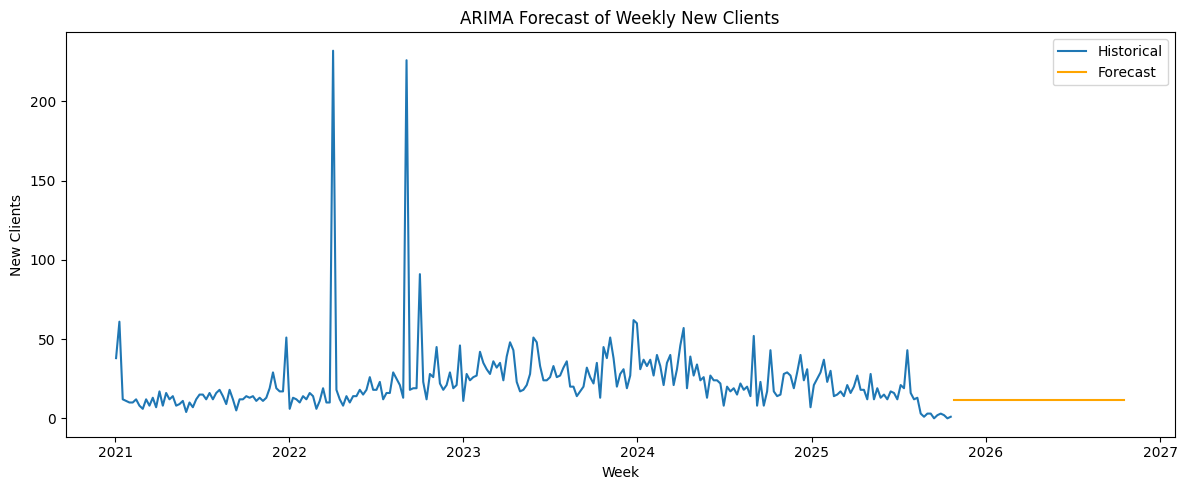

In [49]:
# cell 18

n_weeks = 52  # forecast 1 year
forecast = model.predict(n_periods=n_weeks)
forecast_index = pd.date_range(start=weekly.index[-1] + pd.Timedelta(weeks=1),
                               periods=n_weeks, freq="W-SUN")

forecast_series = pd.Series(forecast, index=forecast_index)

plt.figure(figsize=(12,5))
plt.plot(weekly, label="Historical")
plt.plot(forecast_series, label="Forecast", color="orange")
plt.title("ARIMA Forecast of Weekly New Clients")
plt.xlabel("Week")
plt.ylabel("New Clients")
plt.legend()
plt.tight_layout()
plt.show()

In [50]:
# cell 19

forecast_df = forecast_series.to_frame(name="forecast_weekly_new_clients")
forecast_df.to_csv(out_dir / "forecast_weekly_new_clients_arima.csv")

print("Saved to:", out_dir / "forecast_weekly_new_clients_arima.csv")

Saved to: C:\Users\emili\IdeaProjects\PythonProject\ConcordIA\ethnicity_forecasting\forecast_weekly_new_clients_arima.csv
